### Assignment 1 - 4th Year Semester 1 2024

Adam Collins: 21332967

Italo da Silva: 21326312

The Code executes to the end without an error. 

In [402]:
# TODO: Remove this part before submission
import warnings
import os
import tensorflow as tf

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [377]:
# 1. The Data Set 
#   (a). Visualisation of key attributes.

# Loading the csv file and viewing first rows using pandas library
housing_data = pd.read_csv('Melbourne_housing_FULL.csv', low_memory=False) 

# Filtering the Dataset
# Dropping every cell that contains a NaN value (there was alot)
columns = ["Suburb","Rooms","Type","Price","Method","SellerG","Date","Distance","Bedroom2","Bathroom","Car","Landsize","BuildingArea","YearBuilt","CouncilArea","Lattitude","Longtitude","Regionname","Propertycount"]
housing_data = housing_data.dropna(subset=columns)

# Dropping all the columns that don't contain numbers (there was alot too )
housing_data.drop(["Suburb", "Address", "Type", "Method", "SellerG", "CouncilArea", "Regionname", "Date"], inplace=True, axis="columns")
housing_data.head()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
2,2,1035000,2.5,3067,2,1,0,156,79,1900,-37.8079,144.9934,4019.0
4,3,1465000,2.5,3067,3,2,0,134,150,1900,-37.8093,144.9944,4019.0
6,4,1600000,2.5,3067,3,1,2,120,142,2014,-37.8072,144.9941,4019.0
11,3,1876000,2.5,3067,4,2,0,245,210,1910,-37.8024,144.9993,4019.0
14,2,1636000,2.5,3067,2,1,2,256,107,1890,-37.806,144.9954,4019.0


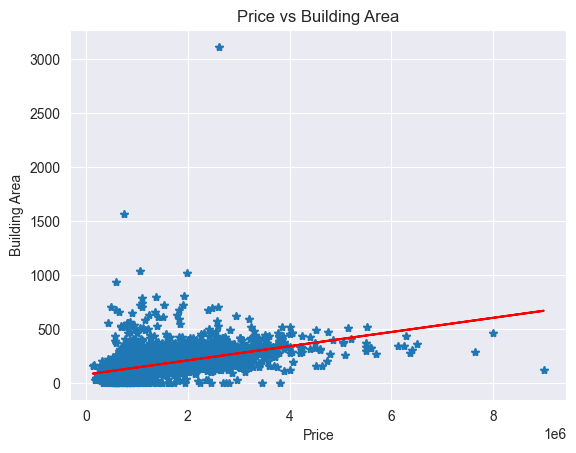

In [378]:
# Draw graph of correlation between Price and Building Area

## Converting the data in the columns to numeric 
housing_data[['Price', 'BuildingArea']] = housing_data[['Price', 'BuildingArea']].apply(pd.to_numeric)

## Reshaping the data to a 2D array in order to plot it in the Linear Regression 
price = housing_data['Price'].values.reshape(-1,1)
building_area = housing_data['BuildingArea'].values.reshape(-1,1)

## Creating a Linear Regression model to predict the data for Building Area based on the Price
reg = LinearRegression().fit(price, building_area)

## Functions to plot the graph
plt.plot(housing_data[['Price']], housing_data[['BuildingArea']], '*')
plt.plot(housing_data[['Price']], reg.predict(price), 'r')

## Adding labels to the graph
plt.xlabel('Price')
plt.ylabel('Building Area')
plt.title('Price vs Building Area')
plt.show()

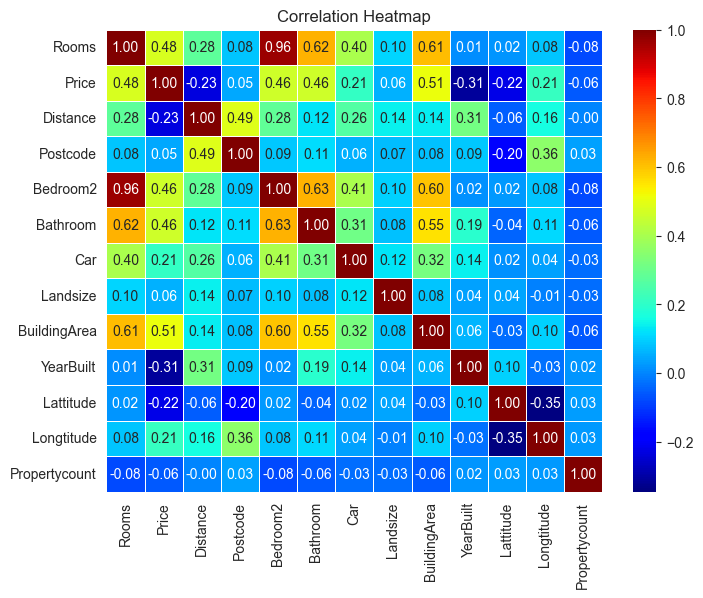

In [379]:
# Code from sample Assignment 1 provided by the lecturer.

# Dataframe of key attributes
housing_data.corr()

# Correlation matrix
corr_matrix = housing_data.corr()

# Generate Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='jet', cbar=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [380]:
# # 1. The Data Set 
#   (b). Pre-Processing - Normalisation

# Normalizing the data
scaler = MinMaxScaler()
housing_data[['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Propertycount']] = scaler.fit_transform(housing_data[['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Propertycount']])

# Dropping Postcode, Landsize and Propertycount as the values are very close to 0
# Also dropping Longitude and Langitude columns as they're useless for correlating price as we already have a Distance (to CBD) column.

housing_data.drop(["Postcode", "Landsize", "Propertycount", "Longtitude", "Lattitude"], inplace=True, axis="columns")

# Since we dropped alot of rows previously due to NaN values and Unnecessary data, the rows index stayed the same.
# So we now need to reset the index back to normal to avoid confusion and keep them in order.
housing_data = housing_data.reset_index(drop=True)

housing_data.head()

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,BuildingArea,YearBuilt
0,0.090909,0.101928,0.052743,0.166667,0.000,0.0,0.025386,0.855407
1,0.181818,0.150412,0.052743,0.250000,0.125,0.0,0.048201,0.855407
2,0.272727,0.165633,0.052743,0.250000,0.000,0.2,0.045630,0.993925
3,0.181818,0.196753,0.052743,0.333333,0.125,0.0,0.067481,0.867558
4,0.090909,0.169692,0.052743,0.166667,0.000,0.2,0.034383,0.843256


In [381]:
rows = len(housing_data.axes[0])
columns = len(housing_data.axes[1])

print("Number of columns: ", columns)
print("Number of rows: ", rows)

Number of columns:  8
Number of rows:  17774


In [382]:
# Select the features and target variable
# Correlating the price of each property based on it's features
features = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'BuildingArea','YearBuilt']

x = housing_data[features]
y = housing_data['Price']

# Dividing the price column into 5 sections (labels) in order to classify correctly and can be used in the output layer of our model.

# label 0 = 0.00 to 0.15 (first section)
# label 1 = 0.15 to 0.38 (second section)
# label 2 = 0.38 to 0.62 (third section)
# label 3 = 0.62 to 0.85 (fourth section)
# label 4 = 0.85 to 1.00 (last section)

y = pd.cut(y, bins=[0.00, 0.15, 0.38, 0.62, 0.85, 1.00], labels=[0, 1, 2, 3, 4])
print(y)

# In order to validate and evaluate the model, we are splitting the dataset into two parts, training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

print("\nx_train shape: ", x_train.shape[0])
print("x_test shape: ", x_test.shape[0])

0        0
1        1
2        1
3        1
4        1
        ..
17769    0
17770    0
17771    0
17772    0
17773    0
Name: Price, Length: 17774, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

x_train shape:  13330
x_test shape:  4444


In [383]:
# 2. Hyperparameter
EPOCHS = 100
BATCH_SIZE = 128
LEARNING_RATE = 0.01
VERBOSE = 1
VALIDATION_SPLIT = 0.2
NB_CLASSES = 5
N_HIDDEN = 24

# One hot representation of the samples (Lab3 - Exercise 2)
y_train = tf.keras.utils.to_categorical(y_train, NB_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NB_CLASSES)

# Defining model
model = tf.keras.models.Sequential()

# Add layers to the model
model.add(tf.keras.layers.Dense(N_HIDDEN, input_shape=(len(features),), name='dense-layer', activation='relu'))

# Softmax classification - Converts the output for each class to a probability value between 0-1, which is exponentially normalized among the classes. 
model.add(tf.keras.layers.Dense(NB_CLASSES, activation='softmax'))

# 3. Adaptive Moment Estimation (Adam) optimiser:
# We chose this optimiser because of its adaptive learning rates and optimization efficiency. 
# It also applies bias correction during the early iterations of training, ensuring faster convergence and a stable training process.
optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Compile the model with categorical_crossentropy loss function, we are using this function
# because it computes the loss between the labels (the price labels we have previously classified) and predictions
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

# Evaluate the model
print("\nEvaluate model")
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("\nTest accuracy: %.4f" % test_accuracy)
print("Test loss: %.4f" % test_loss)

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense-layer (Dense)             │ (None, 24)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 5)              │           125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 317 (1.24 KB)

 Trainable params: 317 (1.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5705 - loss: 1.0675 - val_accuracy: 0.7963 - val_loss: 0.4621
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.8190 - loss: 0.4330 - val_accuracy: 0.8353 - val_loss: 0.3838
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.8382 - loss: 0.3919 - val_accuracy: 0.8417 - val_loss: 0.3685
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.8447 - loss: 0.3727 - val_accuracy: 0.8440 - val_loss: 0.3605
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.8437 - loss: 0.3768 - val_accuracy: 0.8458 - val_loss: 0.3557
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.8515 - loss: 0.3619 - val_accuracy: 0.8477 - val_loss: 0.3524
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.8519 - loss: 0.3547 - val_accuracy: 0.8447 - val_loss: 0.3535
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.8471 - loss: 0.3660 - val_accura

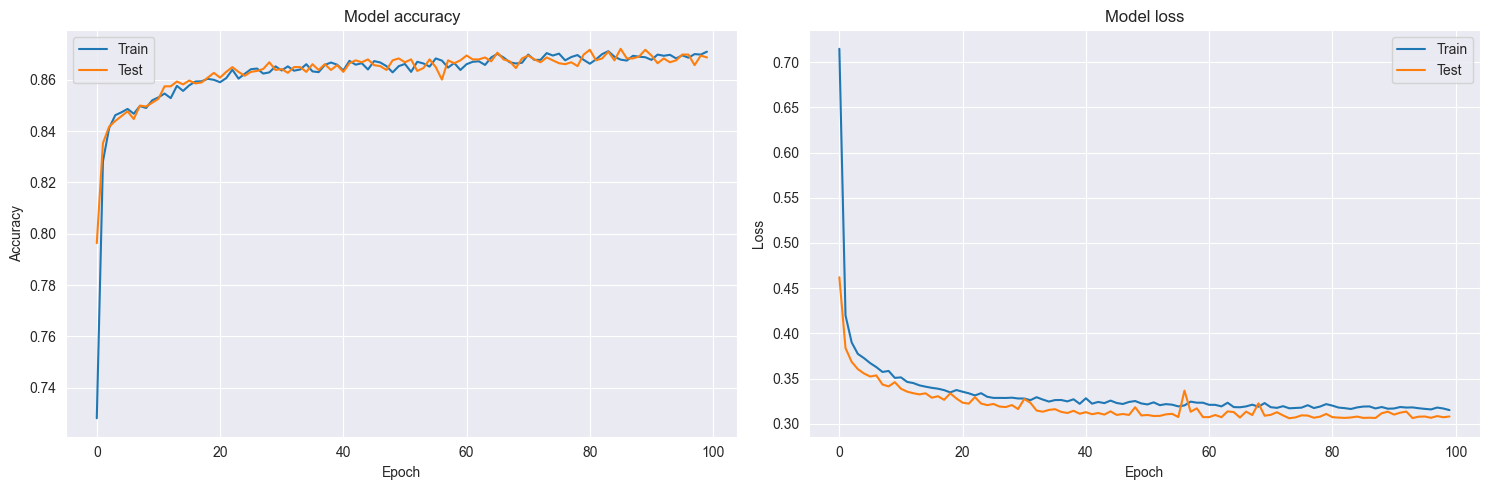

In [401]:
# Plotting graphs on the model's accuracy and loss

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()

In [385]:
# TODO: Work in progress
# 4. Cross Fold Validation
cv = KFold(n_splits=10, random_state=1, shuffle=True)
score = cross_val_score(model, x_test, model.predict(x_test), scoring='accuracy', cv=cv, n_jobs=-1)
print("\nCross Validation Accuracy: %.4f" % (np.mean(score), np.std(score)))

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step


TypeError: Cannot clone object '<Sequential name=sequential_40, built=True>' (type <class 'keras.src.models.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.